# Targeting

## Fake data

In [8]:
import pandas as pd
import numpy as np
from faker import Faker

def create_customer_data(num_customers=1000):
    fake = Faker()
    np.random.seed(42)
    
    # Define means and covariance matrix for the correlated variables
    means = [500, 5000, 0.15, 0.2]  # Mean values for volume, expected_clv, growth_rate, roi
    cov_matrix = [
        [1000, -2500, -0.02, -0.04],
        [-2500, 100000, -1, -2],
        [-0.02, -1, 0.01, 0.02],
        [-0.04, -2, 0.02, 0.04]
    ]  # Covariance matrix with specified correlation
    
    correlated_data = np.random.multivariate_normal(means, cov_matrix, size=num_customers)
    
    customer_data = []
    
    for i in range(num_customers):
        customer_id = fake.uuid4()
        volume = max(1, round(correlated_data[i, 0]))  # Ensure volume is at least 1
        expected_clv = round(max(100, correlated_data[i, 1]), 2)  # Ensure expected_clv is at least 100
        growth_rate = round(max(0.01, min(0.3, correlated_data[i, 2])), 2)  # Ensure growth_rate is between 0.01 and 0.3
        roi = round(max(-1, min(1, correlated_data[i, 3])), 2)  # Ensure roi is between -1 and 1
        cac = round(np.random.uniform(50, 5000), 2)
        dim_1 = fake.random_int(min=1, max=5)
        dim_2 = fake.random_element(elements=('A', 'B', 'C', 'D', 'E'))
        dim_3 = fake.random_number(digits=2)
        
        customer_data.append([
            customer_id,
            volume,
            growth_rate,
            expected_clv,
            cac,
            roi,
            dim_1,
            dim_2,
            dim_3
        ])
    
    columns = ['customer_id', 'volume', 'growth_rate', 'expected_clv', 'cac', 'roi', 'dim_1', 'dim_2', 'dim_3']
    return pd.DataFrame(customer_data, columns=columns)

# Generate the data
data = create_customer_data()
data

,customer_id,volume,growth_rate,expected_clv,cac,roi,dim_1,dim_2,dim_3
0,97ecde94-5443-43fd-a980-d28c1e135150,500,0.08,5157.18,2450.84,0.07,1,D,11
1,3f5fefe3-7dfe-4b8f-83c6-15a1e491f71b,509,0.01,4926.14,472.74,-0.11,1,D,86
2,8009ea5d-f93f-48cf-97c5-db21ce5daf4b,487,0.20,4851.12,4863.68,0.30,5,C,73
3,c6cd0aaa-319c-4713-95a1-9d0710f0f799,557,0.30,5077.99,2614.15,0.54,4,D,7
4,d647e9c4-65ce-45f0-aa95-aaf774ee0a38,498,0.24,4679.47,3090.22,0.39,2,B,19
...,...,...,...,...,...,...,...,...,...
995,7d4e7852-592c-445e-941d-2b5501b42d12,439,0.01,5429.61,1703.53,-0.43,5,E,87
996,6ddcbd4a-2b50-4d1f-a93b-0bfe1f4b6295,562,0.09,5078.41,578.76,0.08,3,C,62
997,48d14531-2bc7-4f9c-acf7-0aeef2faf685,508,0.30,5608.84,1232.28,0.52,2,B,46
998,86f17959-ef5b-4bcd-92c5-f95147c5875f,493,0.30,4374.72,4748.94,0.63,1,A,29


## Multi-objective targeting: Volume vs value

/var/folders/65/1b1td3_n3f977_x9vc2b967w0000gn/T/ipykernel_78494/1483538132.py:12: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(data[dim]) or data[dim].dtype == object:


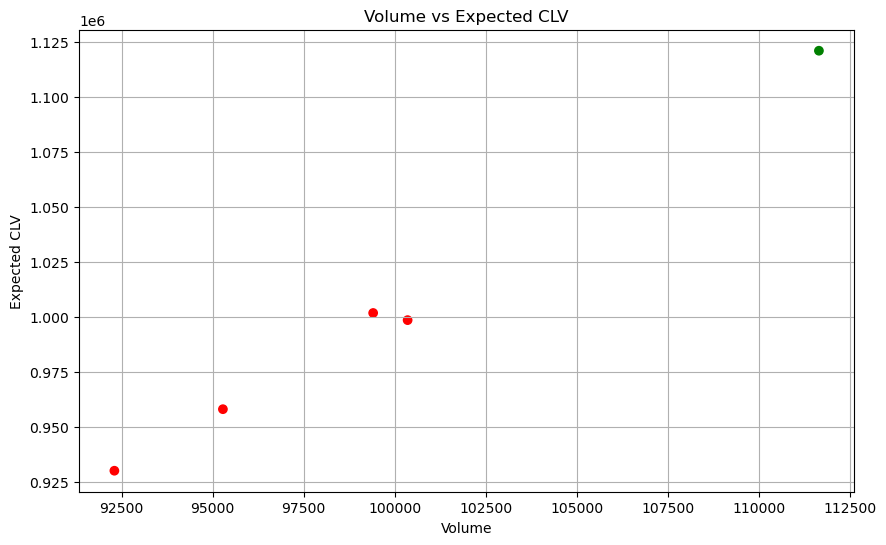

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def targeting_vv(data, volume_col='volume', clv_col='expected_clv', dim=None):
    def is_dominated(row, df):
        return any(
            (df[volume_col] > row[volume_col]) & (df[clv_col] > row[clv_col])
        )
    
    if dim:
        if pd.api.types.is_categorical_dtype(data[dim]) or data[dim].dtype == object:
            # Aggregate by categorical dimension
            aggregated_data = data.groupby(dim).agg({volume_col: 'sum', clv_col: 'sum'}).reset_index()
        else:
            # Aggregate by quartiles if dimension is continuous
            data['quartile'] = pd.qcut(data[dim], 4, labels=False)
            aggregated_data = data.groupby('quartile').agg({volume_col: 'sum', clv_col: 'sum'}).reset_index()
    else:
        aggregated_data = data
    
    # Determine dominated and non-dominated strategies
    aggregated_data['dominated'] = aggregated_data.apply(is_dominated, axis=1, df=aggregated_data)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(aggregated_data[volume_col], aggregated_data[clv_col], c=aggregated_data['dominated'].map({True: 'red', False: 'green'}))
    plt.title('Volume vs Expected CLV')
    plt.xlabel('Volume')
    plt.ylabel('Expected CLV')
    plt.grid(True)
    plt.show()

# Example usage
# Assuming 'data' is a DataFrame containing the relevant columns
data = create_customer_data()
targeting_vv(data, volume_col='volume', clv_col='expected_clv', dim='dim_2')

## Multi-objective targeting: Growth vs ROI

/var/folders/65/1b1td3_n3f977_x9vc2b967w0000gn/T/ipykernel_78494/2532335527.py:12: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(data[dim]) or data[dim].dtype == object:


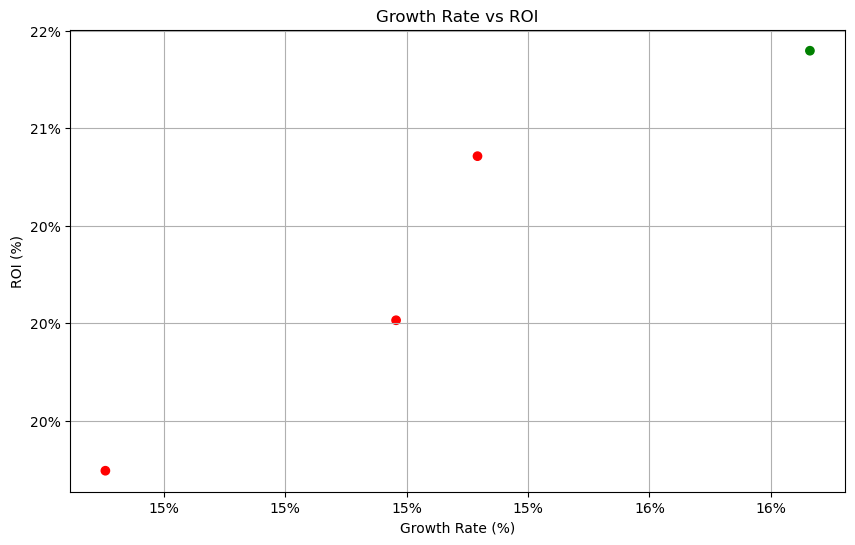

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def targeting_gr(data, gr_col='growth_rate', roi_col='roi', dim=None):
    def is_dominated(row, df):
        return any(
            (df[gr_col] > row[gr_col]) & (df[roi_col] > row[roi_col])
        )
    
    if dim:
        if pd.api.types.is_categorical_dtype(data[dim]) or data[dim].dtype == object:
            # Aggregate by categorical dimension
            aggregated_data = data.groupby(dim).agg({gr_col: 'mean', roi_col: 'mean'}).reset_index()
        else:
            # Aggregate by quartiles if dimension is continuous
            data['quartile'] = pd.qcut(data[dim], 4, labels=False)
            aggregated_data = data.groupby('quartile').agg({gr_col: 'mean', roi_col: 'mean'}).reset_index()
    else:
        aggregated_data = data
    
    # Determine dominated and non-dominated strategies
    aggregated_data['dominated'] = aggregated_data.apply(is_dominated, axis=1, df=aggregated_data)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(aggregated_data[gr_col], aggregated_data[roi_col], c=aggregated_data['dominated'].map({True: 'red', False: 'green'}))
    plt.title('Growth Rate vs ROI')
    plt.xlabel('Growth Rate (%)')
    plt.ylabel('ROI (%)')
    plt.grid(True)
    plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
    plt.show()

# Example usage
# Assuming 'data' is a DataFrame containing the relevant columns
data = create_customer_data()
targeting_gr(data, gr_col='growth_rate', roi_col='roi', dim='dim_1')